# Markov chain Monte Carlo: Metropolis Hastings

In [101]:
import hypothesis
import matplotlib.pyplot as plt
import torch

from hypothesis.inference.mcmc import MetropolisHastings

As in every Bayesian inference setting we have to define a prior $p(\theta)$, which is in our case $\mathcal{U}(-30, 30)$.

In [102]:
from torch.distributions.uniform import Uniform

prior = Uniform(-30, 30)

The Metropolis-Hastings sampler needs a proposal (or transition) mechanism to propose states $\theta'$. This can be done using a *transition distribution*. As the target space is univariate, we simply use a `NormalTransition` to generate proposals.

In [103]:
from torch.distributions.normal import Normal as NormalDistribution
import torch


class Transition:
    r""""""

    def log_prob(self, xs, conditionals):
        raise NotImplementedError

    def sample(self, xs, samples=1):
        raise NotImplementedError

    def is_symmetrical(self):
        raise NotImplementedError



class SymmetricalTransition(Transition):

    def is_symmetrical(self):
        return True
    
class NormalTransition(SymmetricalTransition):

    def __init__(self, sigma):
        super(NormalTransition, self).__init__()
        self.sigma = sigma

    def log_prob(self, mean, conditionals):
        normal = NormalDistribution(mean, self.sigma)
        log_probabilities = normal.log_prob(conditionals)
        del Normal

        return log_probabilities

    def sample(self, means, samples=1):
        with torch.no_grad():
            means = means.view(-1, 1)
            normal_samples = torch.randn(means.size(0), samples)
            sigma = self.sigma
            samples = (normal_samples * sigma) + means

        return samples

transition = NormalTransition(1)

The likelihood of the generating process is normal. The log likelihood function in Hypothesis' MCMC samplers accept a parameter $\theta$ (tensor) and a tensor of observations.

In [115]:
from torch.distributions.normal import Normal

SIGMA = 2
TRUTH = 1

def distr(theta=TRUTH, sigma=SIGMA):
    return Normal(theta*theta, sigma)

def log_likelihood(theta, observations):
    return distr(theta).log_prob(observations).sum()

We draw an observation from the forward model using an assumed truth:

In [116]:
import numpy as np
observations = torch.Tensor(np.load('obs1a.npy'))

We setup the Metropolis Hastings sampler using the components specified above:

In [117]:
sampler = MetropolisHastings(prior, log_likelihood, transition)

First, we need to let the Markov chain converge to its stationary distribution. This can be achieved using a *burnin chain*.

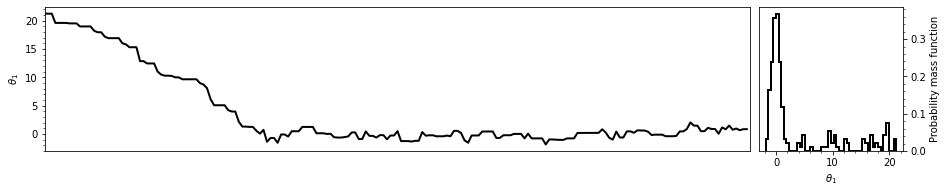

In [118]:
from hypothesis.visualization.mcmc import plot_trace


theta = prior.sample()
burnin_chain = sampler.sample(observations, theta, num_samples=200)

figure = plot_trace(burnin_chain)
plt.show()

In [119]:
burnin_chain.shape

torch.Size([200, 1])

Finally, after the burnin chain converged to its stationary distribution, we let the MetropolisHastings draw samples from the posterior.

Time in seconds :  176.1181906510028


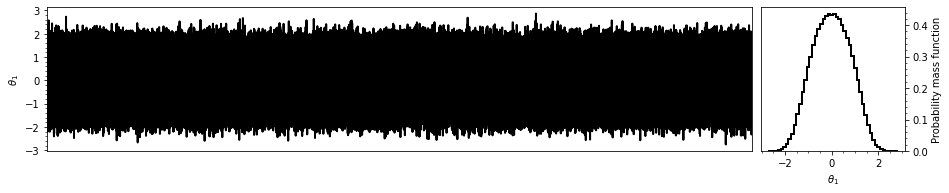

In [120]:
import time
start = time.monotonic()

theta = burnin_chain[-1]
chain = sampler.sample(observations, theta, num_samples=1000000)

end = time.monotonic()

print('Time in seconds : ', end-start)

figure = plot_trace(chain)
plt.show()

In [121]:
np.save('thetas_posterior_1b', chain.samples.numpy())